In [3]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px

import seaborn as sns
import os
import glob

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
from sklearn.metrics import pairwise_distances_argmin_min
import hdbscan
from scipy.cluster.hierarchy import fcluster

import warnings
warnings.filterwarnings("ignore")

In [4]:
def cluster_nuclei_intensity(filename,df,n_neighbors,threshold_q,auto_open,plot_switch):
    embedding = df[['xi','yi','zi']].to_numpy()   
    '''
    Calculate the local curvature of the point cloud embedding
    '''
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    eigvals = [LA.eigvalsh(np.cov(embedding[indices[idx,:],:].T)) for idx in range(embedding.shape[0])] #full data
    curvatures = [min(eigvals[idx])/sum(eigvals[idx]) for idx in range(len(eigvals))]
    # Add curvature to the dataframe
    df['curvature'] = curvatures 
    # Find the minima in curvature histrogram
    q1 = np.quantile(curvatures,threshold_q)
    df1 = df[df['curvature'] <= q1] # define the low curvature sector
    min_cluster_size = round(df1.shape[0]/15) # parameter to be adjausted
    min_samples = round(min_cluster_size/15)       # parameter to be adjausted

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,gen_min_span_tree=True)
    clusterer.fit(df1.loc[:,('xi','yi','zi')]) 
    clusterer.condensed_tree_.plot(select_clusters=True,
                                   selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    plt.show()
    plt.savefig(filename+'.tree.intensity.png')
    plt.close()
    
    df1['clusterID1'] = clusterer.labels_    # add cluster id to dataframe
    df1['clusterID1'] = df1['clusterID1'].apply(str)   # make cluster id a string
    df1_filtered = df1[df1.clusterID1 != str(-1)] # remove unassigned points

    # expand the clusters to the entire point-cloud
    idx, dist = pairwise_distances_argmin_min(df[['xi','yi','zi']].to_numpy(),df1_filtered[['xi','yi','zi']].to_numpy())
    #add 1 to avoid confusion with background
    df['clusterID1'] = [int(df1_filtered.clusterID1.iloc[idx[row]])+1 for row in range(df.shape[0])] 
    df['clusterID1'] = df['clusterID1'].apply(str)
    #    df.to_csv(filename+'.intensity.csv',index=False)
    # plot the spatial projetion    
    if plot_switch:
        fig = px.scatter(df,#1_filtered, 
                         x="cx", y="cy",color="clusterID1",
                        width=800, height=800,
                        color_discrete_sequence=px.colors.qualitative.Set2)
        fig.update_traces(marker=dict(size=2,opacity=1.0))
        fig.update_layout(template='simple_white')
        fig.update_layout(legend= {'itemsizing': 'constant'})
        fig.write_html(filename+'.spatial_projection.intensity.html', auto_open=auto_open)
        
        # plot the low curvature sector
        # fig = px.scatter_3d(df,x="xi", y="yi", z="zi",color="cluster_intensity", hover_name="cluster_intensity",color_discrete_sequence=px.colors.qualitative.Set2)
        # fig.update_traces(marker=dict(size=3,opacity=0.75),selector=dict(mode='markers'))
        # fig.write_html(filename+'.low_curvature_clusters.intensity.html', auto_open=auto_open)
        # fig.write_image(filename+'.low_curvature_clusters.intensity.png')
    return df

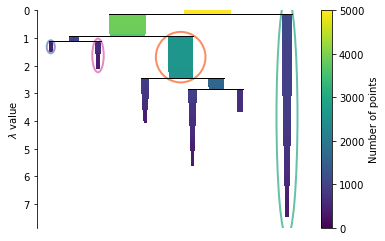

In [5]:
sample_size = 50000 # set to 0 if the entire sample is considered
n_neighbors = 100   # NNN in the curvature calculation
threshold_q = 0.1   # the quantile defining the low-curvature sector
auto_open = True    # switch to open or not html figures in new tab
plot_switch = True  # switch to generate or not html figures

for filename in glob.glob(r'../data_intensity/pkl/id_52.measurements.covd.pkl')[:1]:    # pkl file
    df = pd.read_pickle(filename)
    if sample_size > 0 and sample_size < df.shape[0]:
        df = df.sample(n=sample_size)
    
    df = cluster_nuclei_intensity(filename,df,
                             n_neighbors=n_neighbors,
                             threshold_q=threshold_q,
                             auto_open=auto_open,
                             plot_switch=plot_switch)

In [4]:
features
for c in ['area', 'perimeter', 'solidity', 'eccentricity','circularity', 
          'mean_intensity', 'std_intensity', 'cov_intensity']:
    # define the quantiles interval labels
    df["q_"+c] = pd.qcut(df[c],10,labels=False, duplicates='drop')

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 10))
sns.boxplot(x='clusterID1', y='q_area', data=df, orient="v", ax=axes[0, 0])
sns.boxplot(x='clusterID1', y='q_perimeter', data=df, orient="v", ax=axes[0, 1])
sns.boxplot(x='clusterID1', y='q_solidity', data=df, orient="v", ax=axes[0, 2])
sns.boxplot(x='clusterID1', y='q_circularity', data=df, orient="v", ax=axes[1, 0])
sns.boxplot(x='clusterID1', y='q_eccentricity', data=df, orient="v", ax=axes[1, 1])
sns.boxplot(x='clusterID1', y='q_mean_intensity', data=df, orient="v", ax=axes[1, 2])
sns.boxplot(x='clusterID1', y='q_std_intensity', data=df, orient="v", ax=axes[2, 0])
sns.boxplot(x='clusterID1', y='q_cov_intensity', data=df, orient="v", ax=axes[2, 1])
axes[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 10))
sns.boxplot(x='clusterID1', y='area', data=df, orient="v", ax=axes[0, 0])
sns.boxplot(x='clusterID1', y='perimeter', data=df, orient="v", ax=axes[0, 1])
sns.boxplot(x='clusterID1', y='solidity', data=df, orient="v", ax=axes[0, 2])
sns.boxplot(x='clusterID1', y='circularity', data=df, orient="v", ax=axes[1, 0])
sns.boxplot(x='clusterID1', y='eccentricity', data=df, orient="v", ax=axes[1, 1])
sns.boxplot(x='clusterID1', y='mean_intensity', data=df, orient="v", ax=axes[1, 2])
sns.boxplot(x='clusterID1', y='std_intensity', data=df, orient="v", ax=axes[2, 0])
sns.boxplot(x='clusterID1', y='cov_intensity', data=df, orient="v", ax=axes[2, 1])
axes[2, 2].axis('off')
plt.tight_layout()
plt.show()

1


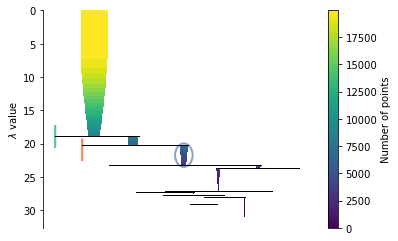

{0, 1, 2, -1}
2


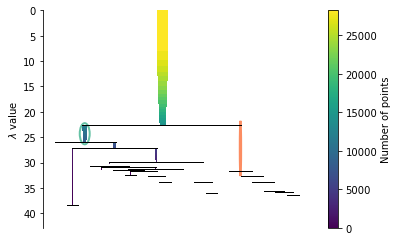

{0, 1, 2, -1}
3


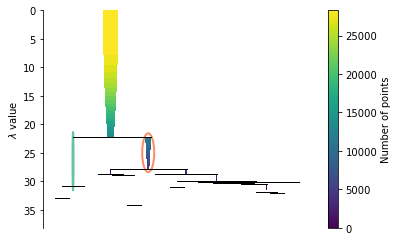

{0, 1, 2, -1}
4


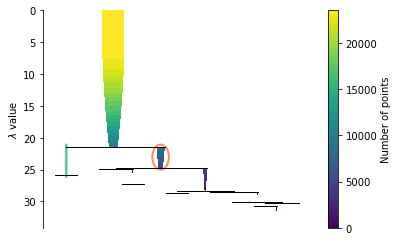

{0, 1, 2, -1}


In [5]:
'''
Add morphology after the covd cluster analysis
For each covd cluster id, cluster based on morphology
!!!!!!!!!!!!!!!!Consider the possibility to perform UMAP before clustering!!!!!!!!!!!!!!!!!!!
'''
from sklearn import preprocessing

# rescale the features to 0-1 range
for feature in ['area', 'perimeter', 'solidity','eccentricity', 'circularity', 
                'mean_intensity', 'std_intensity','cov_intensity'
               ]:
    f = df[feature].as_matrix().reshape(-1,1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    f_scaled = min_max_scaler.fit_transform(f)
    df[feature] = f_scaled

# select the list of features to be clustered
list_of_features = ['area', 
                #'perimeter', 
                    'solidity','eccentricity', 'circularity', 
                # 'mean_intensity', 'std_intensity','cov_intensity'
                   ]

df["clusterID2"] = -1 # initialize the morphological cluster id

for c_id in set(df.clusterID1): # for each cluster1 id
    print(c_id)
    # cluster with HDBSCAN
    min_cluster_size = 20   # parameter to be adjausted
    min_samples = 20       # parameter to be adjausted
    
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples,
                                min_cluster_size=min_cluster_size,
                                gen_min_span_tree=True)
    
    clusterer.fit( df[df["clusterID1"] == c_id][list_of_features] ) 
    
    clusterer.condensed_tree_.plot(select_clusters=True,
                                   selection_palette=sns.color_palette("Set2",len(clusterer.labels_))
                                  )
    #plt.savefig(filename+'.tree.intensity.png')
    plt.show()
    
    #update datarrame
    df.loc[df.clusterID1 == c_id, "clusterID2"] = clusterer.labels_
    print(set(df["clusterID2"] ))

# merge the two cluster ids into a single one
df["clusterID3"] = df["clusterID1"].astype(str) +"_"+df["clusterID2"].apply(str)

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 10))
sns.boxplot(x='clusterID3', y='area', data=df, orient="v", ax=axes[0, 0])
sns.boxplot(x='clusterID3', y='perimeter', data=df, orient="v", ax=axes[0, 1])
sns.boxplot(x='clusterID3', y='solidity', data=df, orient="v", ax=axes[0, 2])
sns.boxplot(x='clusterID3', y='circularity', data=df, orient="v", ax=axes[1, 0])
sns.boxplot(x='clusterID3', y='eccentricity', data=df, orient="v", ax=axes[1, 1])
sns.boxplot(x='clusterID3', y='mean_intensity', data=df, orient="v", ax=axes[1, 2])
sns.boxplot(x='clusterID3', y='std_intensity', data=df, orient="v", ax=axes[2, 0])
sns.boxplot(x='clusterID3', y='cov_intensity', data=df, orient="v", ax=axes[2, 1])
axes[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Define a pairing function to label uniquely pairs of morpho and intensity clusters
def cantor(n,m):
    return 0.5*(n+m)*(n+m+1)+m

df_labeled = df[df["clusterID2"] != -1] # filter out unlabeled morphological clusters
df_labeled["clusterID12"] = cantor(df_labeled["clusterID1"].apply(int),df_labeled["clusterID2"].apply(int) ) 

#define a dictionary to rewrite the paired labels in a continuous numeric way
dic1 = {}
labels = set(df_labeled["clusterID12"])
for counter, value in enumerate(list(labels)):
    dic1[value] = counter # map cluster ID12 to an integer
    
df_labeled['clusterID3'] = df_labeled['clusterID12'].map(dic1) 

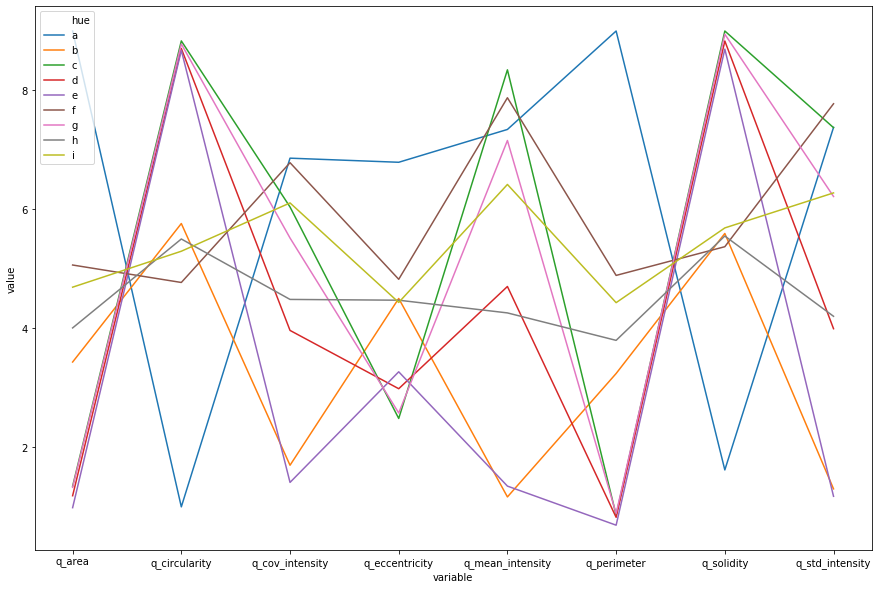

In [7]:
import string
dic2 = {}
for x, y in zip(range(0,len(set(df_labeled["clusterID3"]))), string.ascii_lowercase):
    dic2[x]=y # dict from integers to char

# Plot the morphology profiles by clusterID3
dfmelted = pd.DataFrame()
for c in set(df_labeled["clusterID3"]):
    dfc = df_labeled[df_labeled["clusterID3"] == c][['q_area','q_perimeter',
                                                      'q_solidity', 'q_eccentricity', 
                                                      'q_circularity','q_mean_intensity', 
                                                      'q_std_intensity', 'q_cov_intensity']]
    data = pd.melt(dfc)
    data['hue'] = dic2[c]
    dfmelted = dfmelted.append(data)

plt.figure(figsize=(15,10))
sns.lineplot(x="variable", y="value",hue='hue', data=dfmelted, ci=None,legend='full')
plt.legend(loc='upper left')
plt.show()

In [8]:
# Characterize the morphological profile of clusterID3 by the mean of morpho features
import numpy as np
profiles = np.zeros((len(set(df_labeled["clusterID3"])),
                     len(['q_area','q_perimeter', 
                          'q_solidity', 'q_eccentricity', 
                          'q_circularity','q_mean_intensity', 
                          'q_std_intensity', 'q_cov_intensity'])
                    ))
row = 0
for c in set(df_labeled["clusterID3"]):
    dfc = df_labeled[df_labeled["clusterID3"] == c][['q_area','q_perimeter', 
                                     'q_solidity', 'q_eccentricity', 
                                     'q_circularity','q_mean_intensity', 
                                     'q_std_intensity', 'q_cov_intensity']]
    profiles[row,:] = dfc.mean().values
    row += 1
profiles.shape # an array of size numb_clusters X numb_morpho-features

(9, 8)

In [10]:
# Cluster the profiles with kmeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(profiles)

In [11]:
import string

dic2 = {}
for x, y in zip(set(df_labeled["clusterID3"]), kmeans.labels_):
    dic2[x]=y # map clusterID3 to kmeans labels
df_labeled['clusterID4'] = df_labeled.clusterID3.map(dic2)
df_labeled

,fov_row,fov_col,cx,cy,area,perimeter,solidity,eccentricity,circularity,mean_intensity,...,q_solidity,q_eccentricity,q_circularity,q_mean_intensity,q_std_intensity,q_cov_intensity,clusterID2,clusterID3,clusterID12,clusterID4
165518,20,27,13967.282051,10352.547009,0.217890,0.267870,0.905663,0.253591,0.736078,0.329449,...,8,0,8,6,6,6,1,7,11.0,0
625118,7,18,9318.994318,4005.443182,0.353211,0.423587,0.823594,0.787397,0.507402,0.406123,...,6,7,3,7,8,8,2,5,8.0,0
20575,28,38,19553.917431,14387.715596,0.199541,0.281827,0.821900,0.713400,0.569352,0.695197,...,6,5,5,9,7,4,2,5,8.0,0
648831,10,5,3053.557692,5607.730769,0.188073,0.267870,0.736611,0.496467,0.586136,0.553611,...,4,2,5,8,9,9,2,5,8.0,0
726045,34,35,18392.276786,17766.714286,0.206422,0.267870,0.863547,0.483557,0.678408,0.385459,...,7,2,7,7,4,3,1,7,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667141,24,37,19072.196532,12388.543353,0.346330,0.406739,0.797069,0.766407,0.552205,0.314735,...,5,6,4,6,7,7,1,7,11.0,0
664639,19,38,19474.074074,10094.111111,0.073394,0.129000,0.782941,0.721752,0.688723,0.350158,...,5,5,7,6,8,9,1,8,16.0,0
159411,2,24,12319.797619,1506.547619,0.142202,0.207457,0.913409,0.713631,0.678958,0.175432,...,9,5,7,3,4,4,1,7,11.0,0
543613,36,41,21182.895833,18519.156250,0.169725,0.244043,0.796828,0.575011,0.621040,0.816771,...,5,3,6,9,8,5,1,8,16.0,0


In [12]:
dic3 = {}
for x, y in zip(set(df_labeled["clusterID4"]),string.ascii_uppercase):
    dic3[x]=y # map clusterID4 to color hue
df_labeled['clusterID4_hue'] = df_labeled.clusterID4.map(dic3)

In [27]:
fig = px.scatter(df_labeled,
                 x="cx", y="cy",color="clusterID4_hue",
                 width=800, height=800,
                 color_discrete_sequence=px.colors.qualitative.Set2)
fig.update_traces(marker=dict(size=10,opacity=0.75))
fig.update_layout(template='simple_white')
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.write_html('test.spatial_projection.intensity.html', auto_open=auto_open)
        

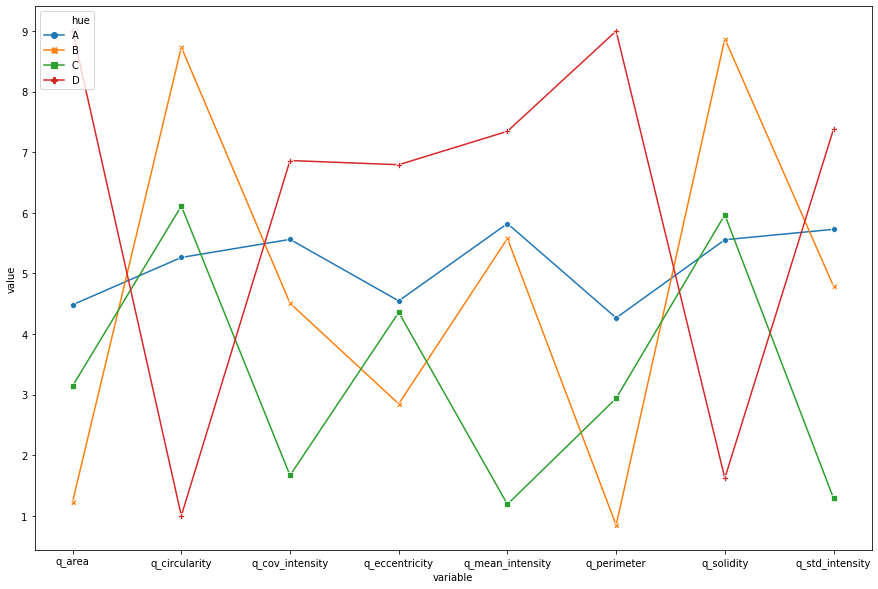

In [24]:
import string
dic2 = {}
for x, y in zip(range(0,len(set(df_labeled["clusterID4"]))), string.ascii_uppercase):
    dic2[x]=y # dict from integers to char

# Plot the morphology profiles by clusterID3
dfmelted = pd.DataFrame()
for c in set(df_labeled["clusterID4"]):
    dfc = df_labeled[df_labeled["clusterID4"] == c][['q_area','q_perimeter',
                                                      'q_solidity', 'q_eccentricity', 
                                                      'q_circularity','q_mean_intensity', 
                                                      'q_std_intensity', 'q_cov_intensity']]
    data = pd.melt(dfc)
    data['hue'] = dic2[c]
    dfmelted = dfmelted.append(data)

plt.figure(figsize=(15,10))
sns.lineplot(x="variable", y="value",hue='hue',style='hue', 
             data=dfmelted, ci=None,legend='full',
             markers=True, dashes=False)
plt.legend(loc='upper left')
plt.show()